# IMPORT MODULES

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
#from keras.models import load_model
import keras.backend as k1
from sklearn.model_selection import train_test_split
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,Convolution2D,AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121,DenseNet169

#from keras.applications.densenet import preprocess_input
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from glob import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Data Read

In [3]:
path='Data/'
l=glob(path+"*")
s=len(glob(path+"*"))
print(l)

['Data\\Healthy', 'Data\\Unhealthy']


# Data Extraction

In [4]:
path='Data/'
l=glob(path+"*")
s=len(glob(path+"*"))
extract=[]
name_items=[]
for i in l:
    name_items.append(i[5:])
print(name_items)

flat_data_arr=[] #input array
target_arr=[] #output array
for j in name_items:
    m=glob(path+j+"/*")
    for h in m:
        s = cv2.imread(h, cv2.IMREAD_COLOR) 
        try:      
            s= cv2.resize(s, (224,224))
            s= cv2.cvtColor(s, cv2.COLOR_BGR2RGB)
        except:
          break
        extract.append([np.array(s),j])
print(len(extract))
ex=extract

['Healthy', 'Unhealthy']
1221


# Labelling the Images

In [17]:
import os
from PIL import Image

# Define the paths to the folders
healthy_folder = 'Data/Healthy/'
unhealthy_folder = 'Data/Unhealthy/'

# Define empty lists for data and labels
data = []
labels = []

# Loop over the healthy folder
for image_path in os.listdir(healthy_folder):
    # Read the image and convert it to numpy array
    try:
      image = Image.open(os.path.join(healthy_folder, image_path)).convert('RGB')
      # Check image shape and resize if necessary
      if image.size != (224, 224):
        image = image.resize((224, 224))
    # Append the image to the data list and the label to the labels list
      data.append(np.array(image))
      labels.append(0)
    except:
      break

# Loop over the unhealthy folder
for image_path in os.listdir(unhealthy_folder):
    # Read the image and convert it to numpy array
    try:
      image = Image.open(os.path.join(unhealthy_folder, image_path)).convert('RGB')
      # Check image shape and resize if necessary
      if image.size != (224, 224):
        image = image.resize((224, 224))
    # Append the image to the data list and the label to the labels list
      data.append(np.array(image))
      labels.append(1)
    except:
      break

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)
# Reshape data array to have a shape of (num_samples, height, width, channels)
data = data.reshape(data.shape[0], 224, 224, 3)

# Display the Labelled Images

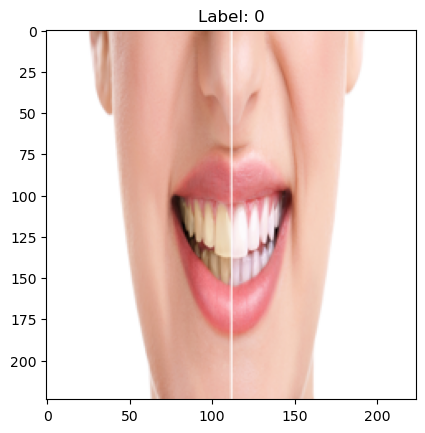

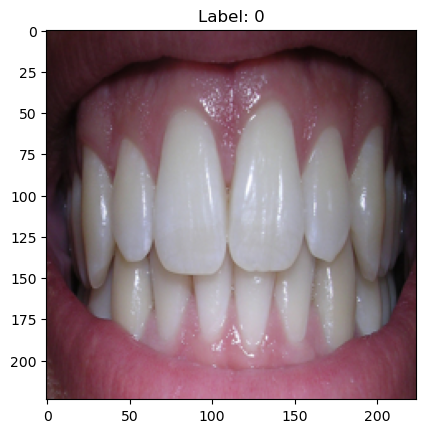

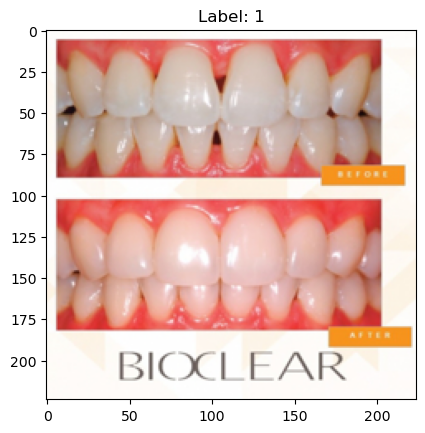

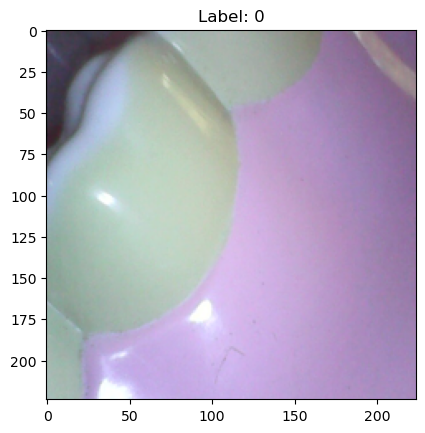

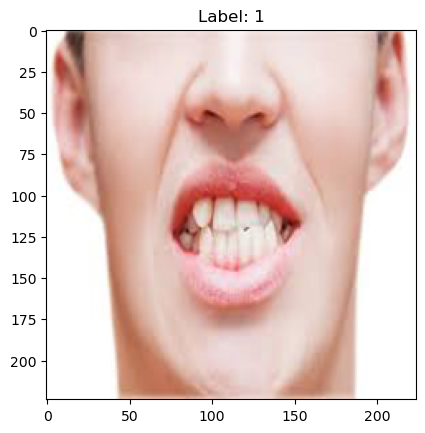

In [32]:
import matplotlib.pyplot as plt

# Print the first 5 images along with their labels
for i in range(5):
    plt.imshow(data[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()


In [44]:
data.shape

(1221, 224, 224, 3)

# Using Image Augmentation

In [87]:
# Shuffle the data and labels together
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # only rescale pixel values for validation set

# Define batch size and number of epochs
batch_size = 32
epochs = 20

# Create the data generators for training and validation sets
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

# Session Starts

In [37]:
# input layer (224,224,3) have dim 224X224 and 3 color channels(RGB)
# output layer is of shape (2,) as 2 classes are present 
print(x.shape,y.shape)
k1.clear_session()

(1221, 224, 224, 3) (1221, 2)


# VGG Model

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers so that we don't update their weights during training
for layer in vgg16.layers:
    layer.trainable = False

# Define the top layers of the model
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model

In [89]:
# Train the model with fit_generator method
history = model.fit_generator(train_generator, steps_per_epoch=len(x_train) // batch_size,
                              epochs=epochs, validation_data=val_generator,
                              validation_steps=len(x_val) // batch_size)

C:\Users\Nikita\AppData\Local\Temp\ipykernel_13644\3747603335.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=len(x_train) // batch_size,


Epoch 1/20
30/30 [==============================] - 150s 5s/step - loss: 0.8862 - accuracy: 0.6917 - val_loss: 0.4636 - val_accuracy: 0.7991
Epoch 2/20
30/30 [==============================] - 145s 5s/step - loss: 0.5161 - accuracy: 0.7574 - val_loss: 0.4190 - val_accuracy: 0.8348
Epoch 3/20
30/30 [==============================] - 145s 5s/step - loss: 0.4679 - accuracy: 0.7818 - val_loss: 0.3933 - val_accuracy: 0.8482
Epoch 4/20
30/30 [==============================] - 146s 5s/step - loss: 0.5148 - accuracy: 0.7574 - val_loss: 0.4097 - val_accuracy: 0.8125
Epoch 5/20
30/30 [==============================] - 148s 5s/step - loss: 0.4181 - accuracy: 0.8347 - val_loss: 0.3972 - val_accuracy: 0.8571
Epoch 6/20
30/30 [==============================] - 149s 5s/step - loss: 0.4092 - accuracy: 0.8231 - val_loss: 0.4650 - val_accuracy: 0.7991
Epoch 7/20
30/30 [==============================] - 152s 5s/step - loss: 0.4037 - accuracy: 0.8104 - val_loss: 0.4258 - val_accuracy: 0.8125
Epoch 8/20
30

# Save the Model

In [90]:
model.save('my_vgg_model.h5')

# Histogram

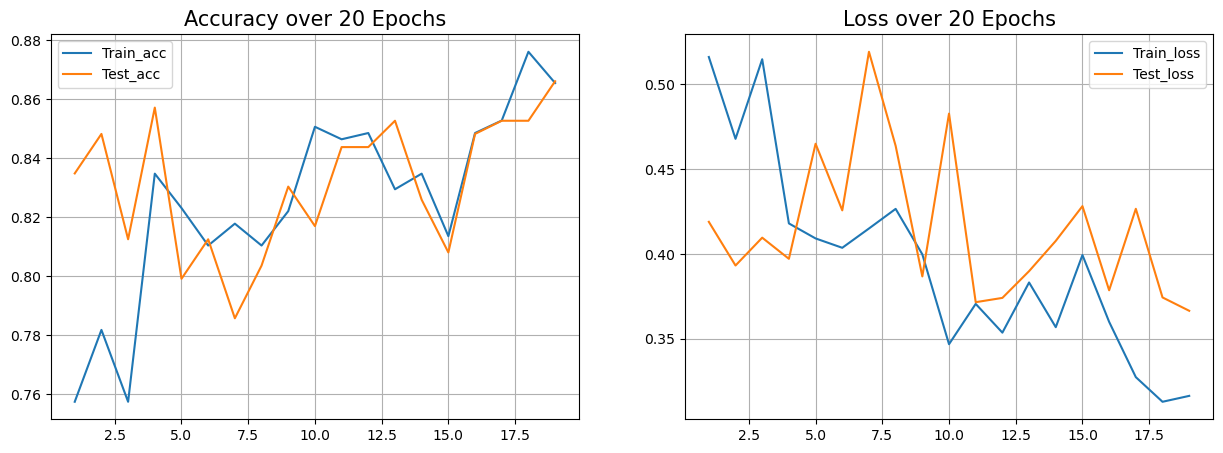

In [113]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
    acc = results.history['accuracy']
    loss = results.history['loss']
    val_acc = results.history['val_accuracy']
    val_loss = results.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_acc_loss(history, 20)

# Load the Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_vgg_model.h5')

# Testing 

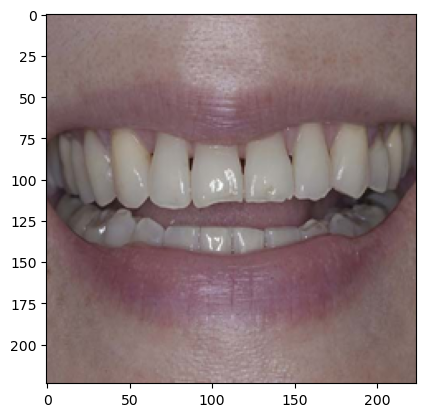

1/1 [==============================] - 0s 136ms/step
0.00048004708
Healthy


In [120]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image and convert it to numpy array
image = Image.open('k.jpg').convert('RGB')
if image.size != (224, 224):
    image = image.resize((224, 224))
image_array = np.array(image).reshape((1, 224, 224, 3))

# Display the image
plt.imshow(image)
plt.show()

# Make a prediction on the image
prediction = model.predict(image_array)
print(prediction[0][0])
if prediction[0][0] > 0.5:
    print('Unhealthy')
else:
    print('Healthy')